In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(0)

# Attention Mechanism

In [2]:
# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Calculate each channels avg and max value in order to let network focus on overall info of different channel
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1), # C//r=1000/16=62
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_channels, in_channels // reduction_ratio),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(in_channels // reduction_ratio, in_channels)
        # )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x=[B, C, H, W]
        avg_out = self.fc(self.avg_pool(x)) # [B, C, 1, 1]
        max_out = self.fc(self.max_pool(x)) # [B, C, 1, 1]
        out = avg_out + max_out
        return self.sigmoid(out)
        #return self.sigmoid(out) * x


In [3]:
# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # DIM is in the first dimension, which is after the batch size, so it is defined as [B,1,H,W].
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]
        x = torch.cat([avg_out, max_out], dim=1) # [B, 2, H, W]
        x = self.conv(x) # [B, 1, H, W]
        return self.sigmoid(x) # [B, 1, H, W] (final attention map)
        #return self.sigmoid(out) * x



## Convolutional Block Attention Module (CBAM)

In [4]:
# Define the CBAM-like Attention Module
class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x) # x* [B, C, 1, 1] = [B, C, H, W]
        x = x * self.spatial_att(x) # x * [B, 1, H, W] = [B, C, H, W]
        return x

# U-Net with Attention

In [18]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [24]:
# Define the U-Net architecture (unchanged)
class SUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SUNet, self).__init__()
        self.spatial_att = SpatialAttention()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e2 = self.spatial_att(e2) * e2
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e3 = self.spatial_att(e3) * e3
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d1 = self.spatial_att(d1) * d1
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d2 = self.spatial_att(d2) * d2
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

# Training Model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Training loop
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

## Datasets

In [27]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

In [28]:
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

## Strat Training

In [29]:
model = SUNet(in_channels=1, out_channels=1).to(device)
# model = UNet(in_channels=1, out_channels=1).to(device)

In [30]:
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 15
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/15], Average Loss: 1.2820
Epoch [2/15], Average Loss: 0.4932
Epoch [3/15], Average Loss: 0.4426
Epoch [4/15], Average Loss: 0.2719
Epoch [5/15], Average Loss: 0.1706
Epoch [6/15], Average Loss: 0.1342
Epoch [7/15], Average Loss: 0.0969
Epoch [8/15], Average Loss: 0.0769
Epoch [9/15], Average Loss: 0.3019
Epoch [10/15], Average Loss: 0.0919
Epoch [11/15], Average Loss: 0.0735
Epoch [12/15], Average Loss: 0.0607
Epoch [13/15], Average Loss: 0.0478
Epoch [14/15], Average Loss: 0.0229
Epoch [15/15], Average Loss: 0.0094


# Evaluation

In [31]:
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

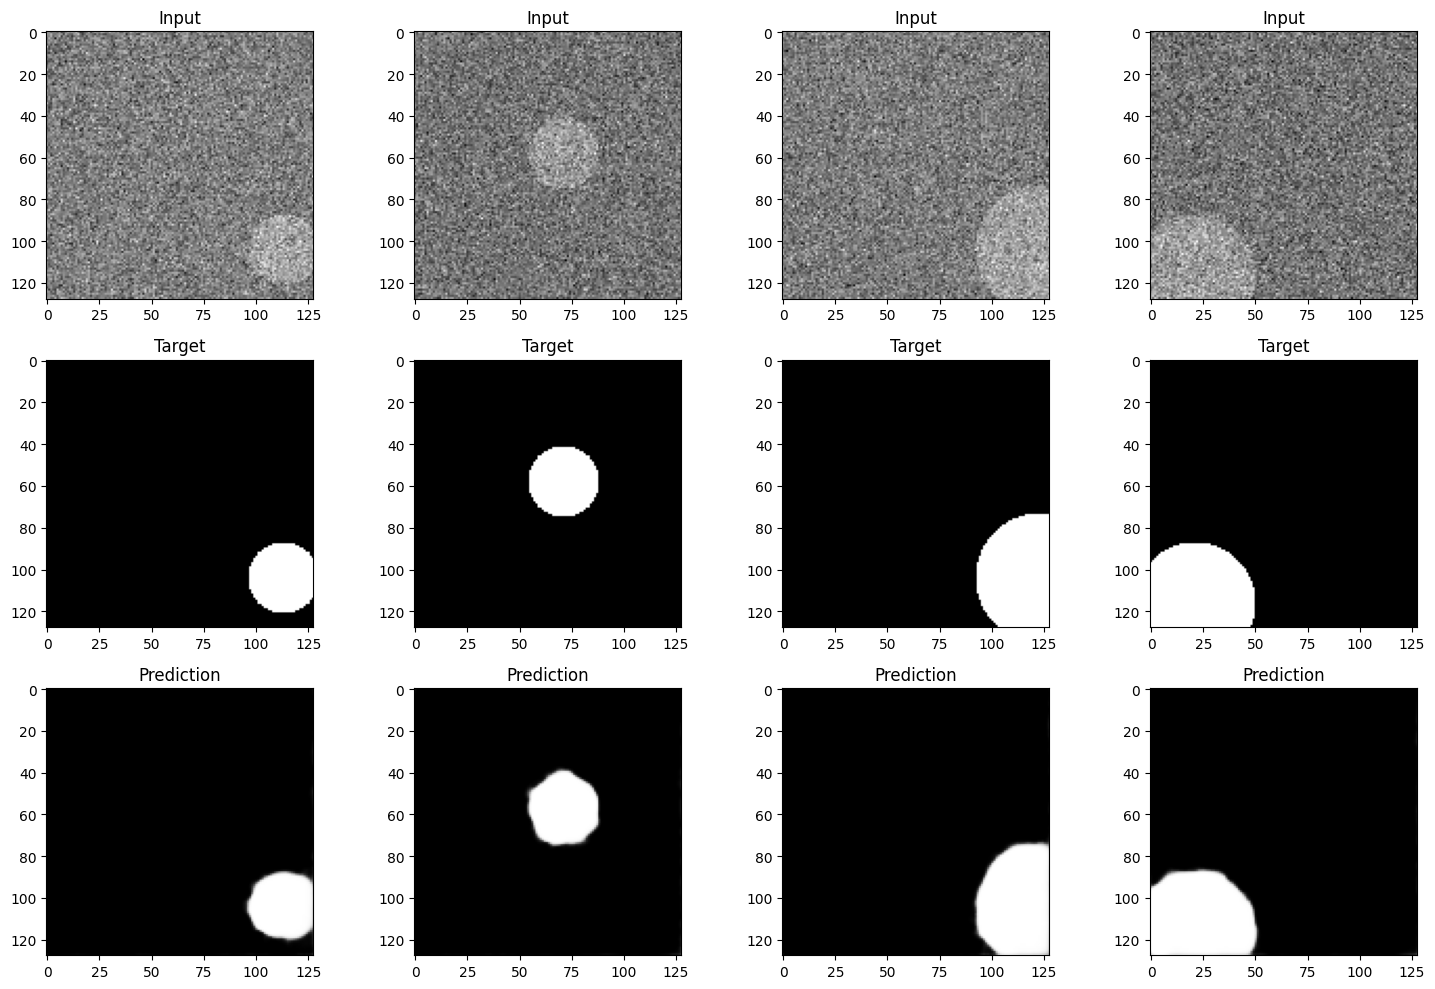

In [32]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()